# Projet 6 : Classifiez automatiquement des biens de consommation

## Étape 1: Classification supervisée via CNN Transfer Learning

### 1.1 Configuration et Prétraitement des Données
- Divisez les images en dossiers pour l'entraînement, la validation et le test.
- Appliquez une data augmentation sur l'ensemble d'entraînement.

In [1]:
# Chargement des bibliothèques nécessaires

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf

from os import listdir
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical



In [2]:
from PIL import Image  # Importer le module Image de la bibliothèque Pillow
# Augmenter la limite de taille des images si nécessaire
Image.MAX_IMAGE_PIXELS = None

In [3]:
# Charger et préparer les données
data = pd.read_csv('data.csv')  

In [4]:
data.head()

,uniq_id,product_name,image,description,brand,category_lvl_1,category_lvl_2,category_lvl_3,main_category,cleaned_text
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,Curtains & Accessories,Curtains,Home Furnishing,eleg polyest multicolor abstract eyelet door c...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care,Baby Bath & Skin,Baby Bath Towels,Baby Care,sathiya cotton bath towelspecif sathiya cotton...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care,Baby Bath & Skin,Baby Bath Towels,Baby Care,eurospa cotton terri face towel setkey featur ...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,Home Furnishing,Bed Linen,Bedsheets,Home Furnishing,santosh royal fashion cotton print king size d...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,Home Furnishing,Bed Linen,Bedsheets,Home Furnishing,jaipur print cotton floral king size doubl bed...


In [5]:
# Identifier les cibles qui sont les 7 catégories qu'on a dans 'main_category'

In [6]:
# Check the distribution of the categories in 'main_category'
category_distribution = data['main_category'].value_counts()

category_distribution

main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [7]:
# Create a DataFrame from the category distribution
category_distribution_df = pd.DataFrame(category_distribution).reset_index()

# Rename the columns for clarity
category_distribution_df.columns = ['Category', 'Count']

# Display the table
category_distribution_df

,Category,Count
0,Home Furnishing,150
1,Baby Care,150
2,Watches,150
3,Home Decor & Festive Needs,150
4,Kitchen & Dining,150
5,Beauty and Personal Care,150
6,Computers,150


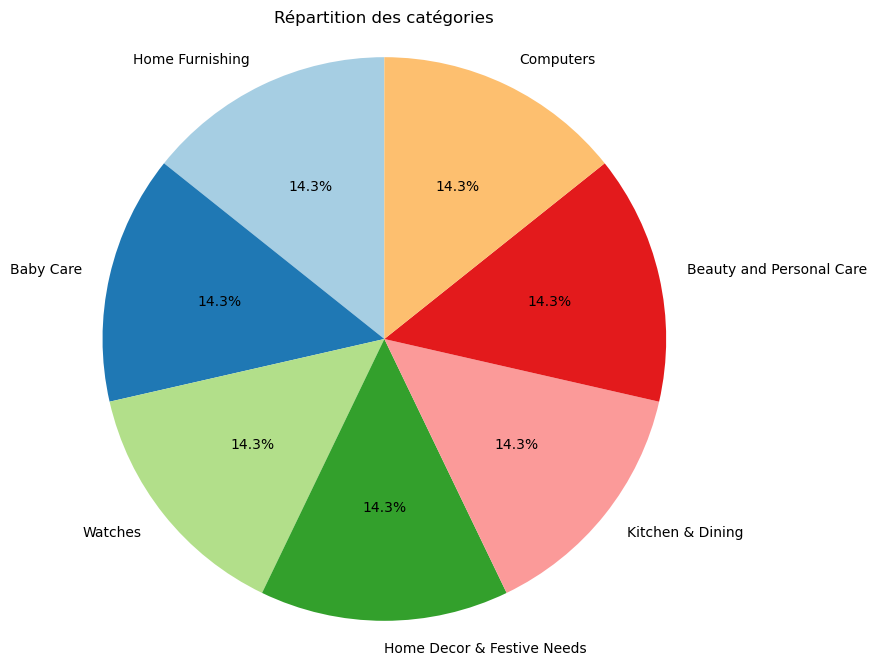

In [8]:

# Préparer les données
categories = category_distribution_df['Category']
counts = category_distribution_df['Count']

# Créer le graphique camembert
plt.figure(figsize=(8, 8))  # Taille du graphique
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Assurer que le graphique est en forme de cercle
plt.axis('equal') 

# Ajouter un titre
plt.title('Répartition des catégories')

plt.savefig("Répartition_catégories.png")

# Afficher le graphique
plt.show()

Category: Home Furnishing


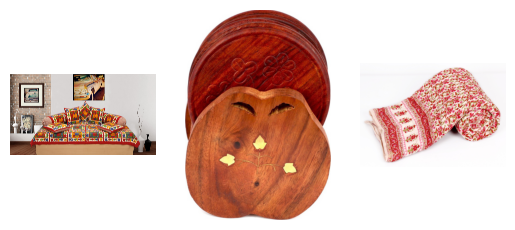

Category: Baby Care


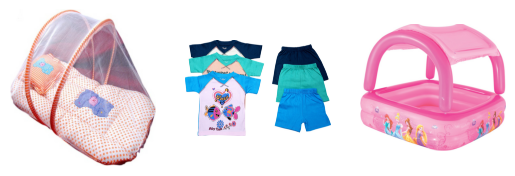

Category: Watches


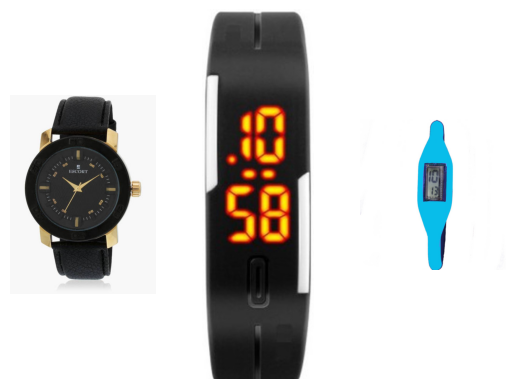

Category: Home Decor & Festive Needs


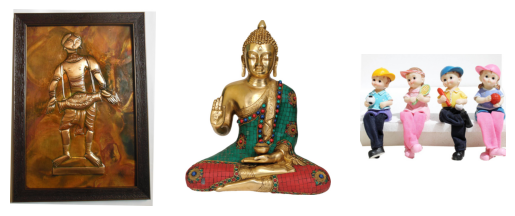

Category: Kitchen & Dining


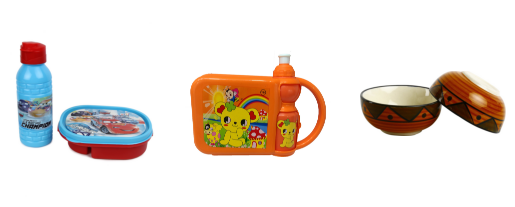

Category: Beauty and Personal Care


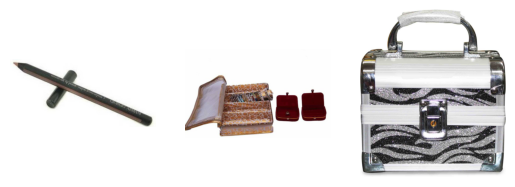

Category: Computers


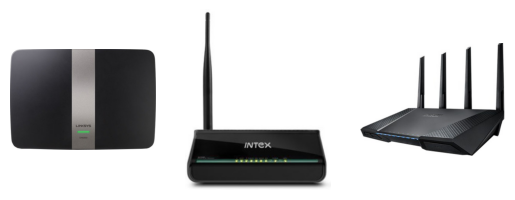

In [9]:
# Afficher des exemples d'images pour chaque catégorie

import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Fonction pour obtenir la liste des chemins d'images pour chaque catégorie
def list_fct(category, data, image_dir):
    # Filtrer les images de la catégorie demandée
    list_image_name = [os.path.join(image_dir, data["image"][i]) for i in range(len(data)) if data["main_category"][i] == category]
    return list_image_name

# Préparation des listes pour chaque catégorie
list_labels = data["main_category"].unique()  # Liste des catégories uniques
image_dir = r'C:\Users\SOUKA\Documents\Images'  # Chemin du dossier des images

# Visualiser 3 images pour chaque catégorie
for name in list_labels:
    print(f"Category: {name}")
    
    # Obtenir la liste d'images pour cette catégorie
    list_images = list_fct(name, data, image_dir)
    
    # Vérifier qu'il y a suffisamment d'images pour afficher
    if len(list_images) >= 13:  # On s'assure d'avoir au moins 13 images (10 + 3)
        # Affichage de 3 images à partir de la 11ème (index 10, 11 et 12)
        for i in range(3):
            plt.subplot(1, 3, i+1)  # Créer 3 sous-graphiques côte à côte
            filename = list_images[i+10]  # Récupérer l'image i+10
            image = imread(filename)
            plt.imshow(image)
            plt.axis('off')  # Ne pas afficher les axes pour les images

        plt.show()  # Afficher les images
    else:
        print(f"Not enough images in category '{name}' to display 3 samples.")

### 1.2. étude de faisabilité

#### Étape 1.2.1 : Création du modèle pré-entraîné

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os

# Charger le modèle VGG16 pré-entraîné sans la couche de classification finale
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# Afficher la structure du modèle
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


#### Étape 1.2.2 : Création des features des images

Le code ci-dessous parcourt chaque image, la redimensionne, l'intègre au modèle VGG16 pour en extraire les caractéristiques.

- data["image"] contient les chemins des images.
- Normalisation des images avec preprocess_input.
- Utilisation de model.predict() pour obtenir les caractéristiques.

In [25]:
# Initialisation de la liste des caractéristiques
images_features = []
i = 0

# Dossier des images
image_dir = r'C:\Users\SOUKA\Documents\Images'

for image_file in data["image"]:
    if i % 100 == 0: 
        print(f"Processing image {i}/{len(data)}")
    i += 1

    # Charger et préparer l'image
    image_path = os.path.join(image_dir, image_file)
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extraire les caractéristiques à partir du modèle
    images_features.append(model.predict(image, verbose=0)[0])

# Convertir en numpy array
images_features = np.asarray(images_features)
print(images_features.shape)

Processing image 0/1050
Processing image 100/1050
Processing image 200/1050
Processing image 300/1050
Processing image 400/1050
Processing image 500/1050
Processing image 600/1050
Processing image 700/1050
Processing image 800/1050
Processing image 900/1050
Processing image 1000/1050
(1050, 4096)


#### Étape 1.2.3 : Réduction de dimension et analyse

Réduction de dimension PCA

Nous utilisons PCA pour réduire les dimensions des caractéristiques extraites.

In [28]:
from sklearn.decomposition import PCA

# Appliquer PCA
print(images_features.shape)
pca = PCA(n_components=0.99)
feat_pca = pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


Réduction de dimension T-SNE et affichage selon les vraies classes

T-SNE permet de réduire encore davantage les dimensions pour une visualisation en 2D.

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Temps de T-SNE : 9.00 secondes


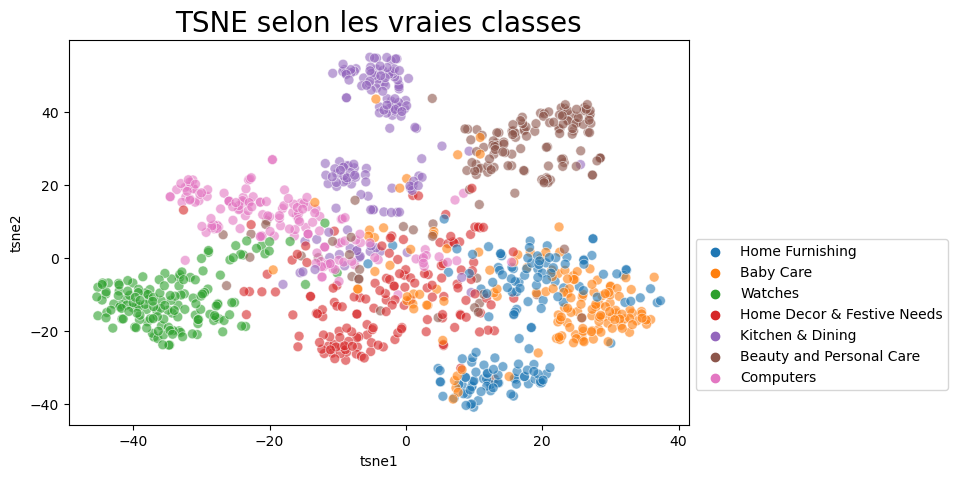

In [31]:
from sklearn import manifold
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Appliquer T-SNE
temps1 = time.time()
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time() - temps1
print(f"Temps de T-SNE : {duration1:.2f} secondes")

# Ajouter les résultats de T-SNE dans un DataFrame pour affichage
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["main_category"]

# Visualisation des vraies classes
plt.figure(figsize=(8,5))
sns.scatterplot(x="tsne1", y="tsne2", hue="class", palette=sns.color_palette('tab10', n_colors=len(data["main_category"].unique())), s=50, alpha=0.6, data=df_tsne, legend="brief")
plt.title('TSNE selon les vraies classes', fontsize=20)
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

#### Étape 1.2.4 : Création de clusters à partir du T-SNE

Bien que nous visualisions les vraies classes, nous pouvons également créer des clusters théoriques pour conforter l'analyse. Ici, nous utilisons KMeans pour créer des clusters à partir des données T-SNE.

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


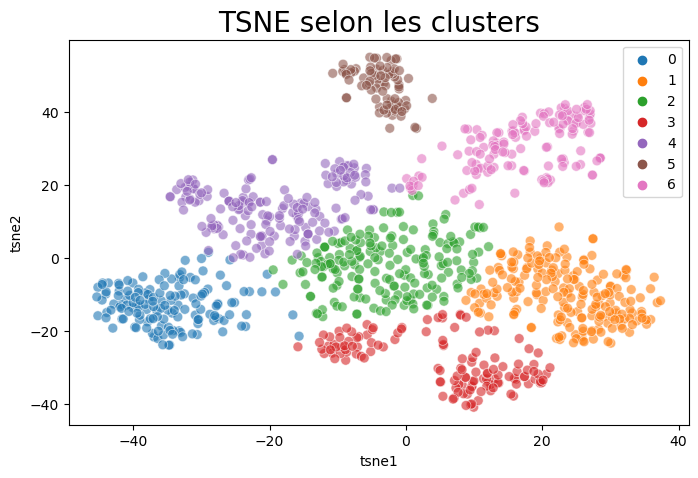

ARI : 0.4393891900971274


In [34]:
from sklearn import cluster, metrics

# Appliquer KMeans pour créer 4 clusters (ou ajuster selon votre nombre de catégories)
cls = cluster.KMeans(n_clusters=len(data["main_category"].unique()), n_init=100)
cls.fit(X_tsne)

# Ajouter les clusters au DataFrame
df_tsne["cluster"] = cls.labels_

# Visualisation selon les clusters
plt.figure(figsize=(8,5))
sns.scatterplot(x="tsne1", y="tsne2", hue="cluster", palette=sns.color_palette('tab10', n_colors=len(data["main_category"].unique())), s=50, alpha=0.6, data=df_tsne, legend="brief")
plt.title('TSNE selon les clusters', fontsize=20)
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend()
plt.show()

# Calculer l'ARI (Adjusted Rand Index)
labels = data["main_category"]
ari_score = metrics.adjusted_rand_score(labels, cls.labels_)
print(f"ARI : {ari_score}")

#### Étape 1.2.5 : Analyse par classes et matrice de confusion
On calcule la matrice de confusion pour observer les correspondances entre les clusters et les vraies classes.

In [ ]:
Étape 1 : Convertir les labels réels en entiers
Vous devez mapper les vraies catégories (qui sont des chaînes de caractères) à des entiers pour correspondre aux labels prédits par KMeans.

In [36]:
# Convertir les labels réels en entiers en utilisant le mapping
from sklearn.preprocessing import LabelEncoder

# Initialiser le LabelEncoder
le = LabelEncoder()

# Appliquer le LabelEncoder sur les vraies catégories
labels_encoded = le.fit_transform(data["main_category"])

# Assurez-vous que cls.labels_ est déjà en format numérique
print(labels_encoded[:10])  # Pour voir les premières valeurs encodées
print(cls.labels_[:10])     # Pour voir les clusters générés par KMeans

[4 0 0 4 4 6 6 6 6 6]
[3 1 1 3 3 0 0 0 0 0]


Étape 1 : Calculer la matrice de confusion et obtenir la correspondance des clusters
Le code suivant utilise une matrice de confusion pour déterminer quelle classe réelle correspond à quel cluster généré par KMeans, et transforme les prédictions en fonction de cette correspondance.

Matrice de confusion initiale : Calcule la correspondance entre les vraies classes (labels) et les clusters (cls.labels_).
Transformation des clusters : Transforme les clusters en classes selon cette correspondance.

In [38]:
from sklearn import metrics
import numpy as np
import pandas as pd

# Fonction pour transformer les labels des clusters en fonction de la correspondance
def conf_mat_transform(y_true, y_pred):
    # Calcul de la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    print("Matrice de confusion initiale :\n", conf_mat)
    
    # Trouver la correspondance entre les clusters et les vraies classes
    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters avec les vraies classes : ", corresp)
    
    # Transformation des prédictions des clusters pour correspondre aux classes réelles
    labels_df = pd.Series(y_true, name="y_true").to_frame()
    labels_df['y_pred'] = y_pred
    labels_df['y_pred_transform'] = labels_df['y_pred'].apply(lambda x: corresp[x])
    
    return labels_df['y_pred_transform']

# Appliquer la transformation des clusters en classes réelles
cls_labels_transform = conf_mat_transform(labels_encoded, cls.labels_)

Matrice de confusion initiale :
 [[  0 110  24   9   2   1   4]
 [  1   7  15   2   6   1 118]
 [  1   1  40   0 106   0   2]
 [  8   7  73  56   5   0   1]
 [  0  75   8  67   0   0   0]
 [  0   1  23   0  36  78  12]
 [135   0   2   0  13   0   0]]
Correspondance des clusters avec les vraies classes :  [6 0 3 4 2 5 1]


Étape 2 : Calcul des métriques de classification (Précision, Rappel, F1-score, etc.)
Après avoir obtenu les clusters transformés en classes, on peut utiliser classification_report pour calculer les métriques.

Matrice de confusion après transformation :
 [[110   4   2  24   9   1   0]
 [  7 118   6  15   2   1   1]
 [  1   2 106  40   0   0   1]
 [  7   1   5  73  56   0   8]
 [ 75   0   0   8  67   0   0]
 [  1  12  36  23   0  78   0]
 [  0   0  13   2   0   0 135]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.55      0.73      0.63       150
           1       0.86      0.79      0.82       150
           2       0.63      0.71      0.67       150
           3       0.39      0.49      0.44       150
           4       0.50      0.45      0.47       150
           5       0.97      0.52      0.68       150
           6       0.93      0.90      0.92       150

    accuracy                           0.65      1050
   macro avg       0.69      0.65      0.66      1050
weighted avg       0.69      0.65      0.66      1050



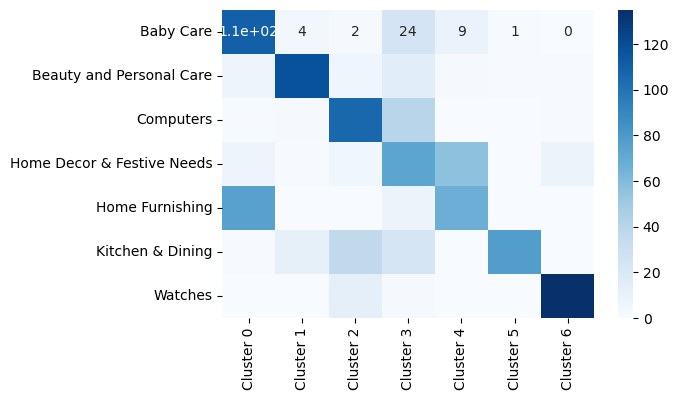

In [40]:
# Calcul de la nouvelle matrice de confusion après transformation
conf_mat = metrics.confusion_matrix(labels_encoded, cls_labels_transform)
print("Matrice de confusion après transformation :\n", conf_mat)

# Afficher le rapport de classification (Précision, Rappel, F1-score, etc.)
classification_report = metrics.classification_report(labels_encoded, cls_labels_transform)
print("Rapport de classification :\n", classification_report)

# Affichage de la matrice de confusion avec Seaborn
df_cm = pd.DataFrame(conf_mat, index=[label for label in le.classes_],
                     columns=[f"Cluster {i}" for i in range(len(le.classes_))])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

- La classe la plus prédite est Watches suivi de Beauty and Personal Care

# 3. Etape 2 : classification supervisée

4 approches sont présentées :

- Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
- Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
- Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
- Une approche par DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

# 3.1. Étape 1 : Création du modèle de classification avec VGG16

In [47]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

def create_model_fct():
    # Charger le modèle pré-entraîné VGG16 sans les couches de classification
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Geler les couches du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Ajouter des couches supplémentaires pour la classification
    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)  # Adapter pour 7 catégories

    # Créer le modèle complet
    model = Model(inputs=model0.input, outputs=predictions)
    
    # Compiler le modèle
    model.compile(loss="categorical_crossentropy", optimizer=RMSprop(), metrics=["accuracy"])

    print(model.summary())
    
    return model

Étape 2 : Préparation initiale des images
Votre dataset contient les chemins des images dans un répertoire séparé. Vous pouvez adapter la fonction image_prep_fct pour charger ces images depuis le dossier spécifié et les redimensionner.

In [50]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def image_prep_fct(data):
    prepared_images = []
    for image_num in range(len(data['image'])):
        img = load_img(data['image'][image_num], target_size=(224, 224))  # Redimensionnement à 224x224
        img = img_to_array(img)
        img = preprocess_input(img)  # Prétraitement spécifique à VGG16
        prepared_images.append(img)
    
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np


In [52]:
# Mettre à jour les chemins des images : Tout d'abord, mettez à jour les chemins d'accès des images dans votre DataFrame.

import os

def update_image_paths(data, image_folder):
    data['image'] = data['image'].apply(lambda x: os.path.join(image_folder, x))
    return data

image_folder = r'C:\Users\SOUKA\Documents\Images'  # Remplacez par le chemin réel vers le dossier contenant vos images
data = update_image_paths(data, image_folder)

In [54]:
# Diviser vos données : Ensuite, divisez votre ensemble de données en ensembles d'entraînement, de validation et de test. Utilisez train_test_split deux fois : d'abord pour créer les ensembles d'entraînement et de test, puis pour diviser l'ensemble d'entraînement en ensembles d'entraînement et de validation.

from sklearn.model_selection import train_test_split

# Diviser les données en entraînement + validation et test
data_train_val, data_test = train_test_split(data, test_size=0.2, stratify=data['main_category'], random_state=42)

# Diviser l'ensemble d'entraînement + validation en entraînement et validation
data_train, data_val = train_test_split(data_train_val, test_size=0.25, stratify=data_train_val['main_category'], random_state=42)

In [56]:
# Préparer les images : Utilisez votre fonction image_prep_fct pour préparer les images pour l'entraînement, la validation et les tests.

def image_prep_fct(data):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.applications.vgg16 import preprocess_input
    
    prepared_images = []
    for image_path in data['image']:
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)  # Prétraitement spécifique à VGG16
        prepared_images.append(img)
    
    return np.array(prepared_images)

# Préparer les images
images_train = image_prep_fct(data_train)
images_val = image_prep_fct(data_val)
images_test = image_prep_fct(data_test)

In [57]:
# Convertir les étiquettes en valeurs numériques : Utilisez LabelEncoder de sklearn pour convertir vos étiquettes de catégories en indices numériques.

from sklearn.preprocessing import LabelEncoder

# Initialiser le LabelEncoder
label_encoder = LabelEncoder()

# Ajuster le LabelEncoder sur l'ensemble des étiquettes
label_encoder.fit(data['main_category'])

# Convertir les étiquettes en indices numériques pour chaque ensemble de données
data_train['main_category_encoded'] = label_encoder.transform(data_train['main_category'])
data_val['main_category_encoded'] = label_encoder.transform(data_val['main_category'])
data_test['main_category_encoded'] = label_encoder.transform(data_test['main_category'])

In [58]:
# Convertir les indices numériques en format catégoriel : Utilisez to_categorical pour convertir les indices en vecteurs catégoriels.

from tensorflow.keras.utils import to_categorical

# Convertir les labels en format catégoriel
X_train = images_train
y_train = to_categorical(data_train['main_category_encoded'])

X_val = images_val
y_val = to_categorical(data_val['main_category_encoded'])

X_test = images_test
y_test = to_categorical(data_test['main_category_encoded'])

1. Création du Modèle
Assurez-vous que la fonction create_model_fct() crée un modèle compatible avec votre problème de classification. Le modèle devrait être adapté à 7 catégories (car vous avez 7 classes).

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

def create_model_fct():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(7, activation='softmax')  # 7 classes
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

2. Création des Callbacks
Vous pouvez utiliser les callbacks ModelCheckpoint et EarlyStopping pour sauvegarder le meilleur modèle et stopper l'entraînement en cas de surapprentissage.

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Créer le modèle
model1 = create_model_fct()

# Définir les callbacks
model1_save_path1 = "./model1_best_weights.keras"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

C:\Users\SOUKA\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
3. Entraînement du Modèle
Entraînez votre modèle en utilisant vos données.

In [76]:
# Entraîner le modèle
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, 
                          callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.5507 - loss: 1.2552
Epoch 1: val_loss did not improve from 1.72054
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 800ms/step - accuracy: 0.5521 - loss: 1.2526 - val_accuracy: 0.3190 - val_loss: 1.7626
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.7264 - loss: 0.9334
Epoch 2: val_loss did not improve from 1.72054
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 803ms/step - accuracy: 0.7266 - loss: 0.9319 - val_accuracy: 0.4095 - val_loss: 2.2975
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8280 - loss: 0.5931
Epoch 3: val_loss did not improve from 1.72054
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 854ms/step - accuracy: 0.8288 - loss: 0.5903 - val_accuracy: 0.4190 - val_loss: 2.3413
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.8955 - loss: 0.3129
Epoch 4: val_loss did not improve from 1.72054
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 839ms/step - accuracy: 0.8958 - loss: 0.3127 - val_accuracy: 0.4286 - val_loss: 2.9

In [ ]:
4. Évaluation du Modèle
Évaluez le modèle sur les ensembles d'entraînement, validation et test.

In [78]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy: {:.4f}".format(accuracy))

# Score de l'epoch optimal
model1.load_weights(model1_save_path1)
loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy : {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       : {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.9753 - loss: 0.1297
Training Accuracy: 0.9778

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.4016 - loss: 3.1414
Validation Accuracy: 0.4381
Validation Accuracy : 0.3048
Test Accuracy       : 0.2952


In [ ]:
5. Visualisation de l'Historique d'Entraînement
Affichez les courbes d'apprentissage.

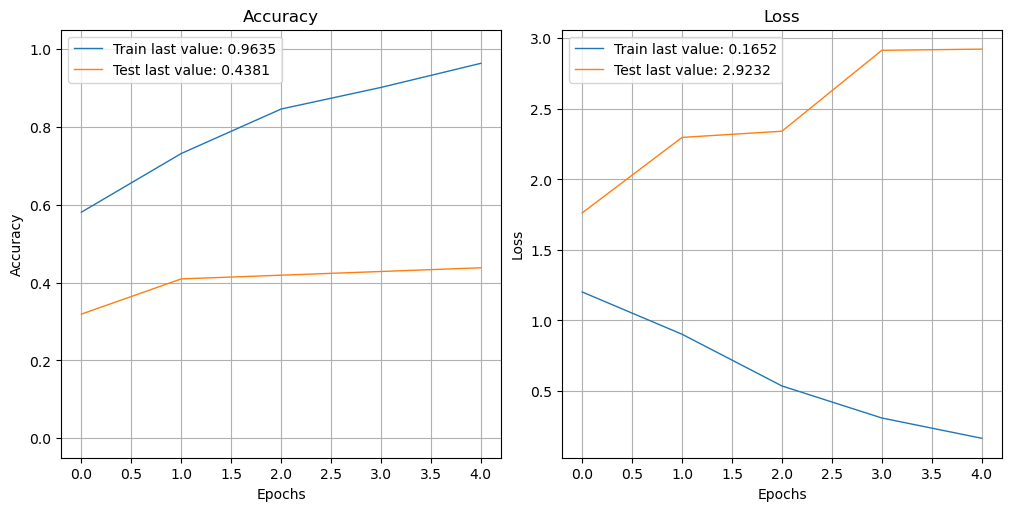

In [79]:

from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [157]:
!pip install plot-keras-history

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of plot-keras-history to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/323.7 kB ? eta -:--:--
     ---- -------------------------------- 41.0/323.7 kB 653.6 kB/s eta 0:00:01
     ------------- ------------------------ 112.6/323.7 kB 1.3 MB/s eta 0:00:01
     ---------------------- --------------- 194.6/323.7 kB 1.5 MB/s eta 0:00:01
     ---------------------- --------------- 194.6/323.7 kB 1.5 MB/s eta 0:00:01
     -------------------------------------- 323.7/323.7 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (set

In [ ]:
6. Matrice de Confusion et Rapport de Classification
Utilisez np.argmax pour obtenir les classes prédites et réelles, et générez la matrice de confusion ainsi que le rapport de classification.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


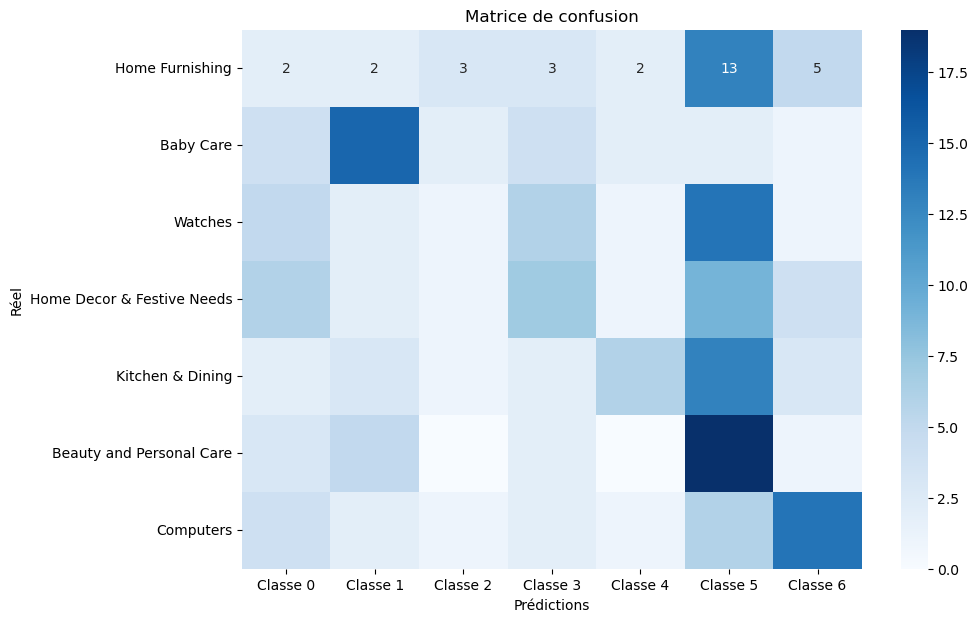

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

# Supposons que vous avez défini `list_labels` comme les catégories réelles
list_labels = data['main_category'].unique()  # Liste des catégories réelles

# Obtenez les indices des véritables étiquettes et des prédictions
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)

# Calcul de la matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)

# Création du DataFrame pour la heatmap
df_cm = pd.DataFrame(conf_mat, index=list_labels, columns=[f'Classe {i}' for i in range(len(list_labels))])

# Affichage de la heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

In [173]:
from sklearn.metrics import classification_report

In [175]:
# Prédictions pour l'approche simple (préparation initiale des images)
y_val_num = np.argmax(y_val, axis=1)  # Vraies étiquettes
y_val_pred = np.argmax(model1.predict(X_val), axis=1)  # Prédictions du modèle

# Rapport de classification pour l'approche 1
print("Approche 1 - Simple par préparation initiale des images")
print(classification_report(y_val_num, y_val_pred, target_names=list_labels))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Approche 1 - Simple par préparation initiale des images
                            precision    recall  f1-score   support

                 Baby Care       0.08      0.07      0.07        30
  Beauty and Personal Care       0.48      0.50      0.49        30
                 Computers       0.11      0.03      0.05        30
Home Decor & Festive Needs       0.27      0.23      0.25        30
           Home Furnishing       0.46      0.20      0.28        30
          Kitchen & Dining       0.25      0.63      0.36        30
                   Watches       0.48      0.47      0.47        30

                  accuracy                           0.30       210
                 macro avg       0.31      0.30      0.28       210
              weighted avg       0.31      0.30      0.28       210



# 3.3. Approche Image Datagenerator avec data augmentation
CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [44]:
# Préparer les données pour ImageDataGenerator
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

batch_size = 32

def data_flow_fct(data, datagen, data_type=None):
    data_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='C:/Users/SOUKA/Documents/Images',  # Chemin vers le dossier contenant les images
        x_col='image',  # Nom de la colonne avec les chemins des images
        y_col='main_category',  # Nom de la colonne avec les labels
        weight_col=None,
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        subset=data_type
    )
    return data_flow

In [46]:
# Création des générateurs de données
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_flow = data_flow_fct(data, datagen_test)

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 1050 validated image filenames belonging to 7 classes.


In [48]:
# Création du modèle
def create_model_fct():
    # Remplacez ceci par la fonction qui crée et retourne votre modèle
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(7, activation='softmax')  # Adapté à vos 7 catégories
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [50]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

In [52]:
# Création des callbacks
model2_save_path = "./model2_best_weights.keras"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [54]:
# Entraînement du modèle
with tf.device('/gpu:0'):
    history2 = model2.fit(
        train_flow,
        validation_data=val_flow,
        epochs=10,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=1
    )


Epoch 1/10


C:\Users\SOUKA\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.1244 - loss: 14.6939 
Epoch 1: val_loss improved from inf to 1.97685, saving model to ./model2_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 802s 32s/step - accuracy: 0.1243 - loss: 14.4519 - val_accuracy: 0.1412 - val_loss: 1.9769
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.1363 - loss: 1.9648 
Epoch 2: val_loss improved from 1.97685 to 1.95552, saving model to ./model2_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 745s 30s/step - accuracy: 0.1365 - loss: 1.9644 - val_accuracy: 0.1107 - val_loss: 1.9555
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1680 - loss: 1.9441 
Epoch 3: val_loss improved from 1.95552 to 1.94669, saving model to ./model2_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 386s 15s/step - accuracy: 0.1677 - loss: 1.9442 - val_accuracy: 0.1145 - val_loss: 1.9467
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.1401 - loss: 1.9455 
Epoch 4: val_loss did not improve 

In [56]:
# Évaluation du modèle
loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))


25/25 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.1785 - loss: 1.9454
Training Accuracy   : 0.1561
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.0998 - loss: 1.9484
Validation Accuracy :  0.1031


In [58]:
# Score de l'epoch optimal
model2.load_weights(model2_save_path)
loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.1145


C:\Users\SOUKA\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy       :  0.1429


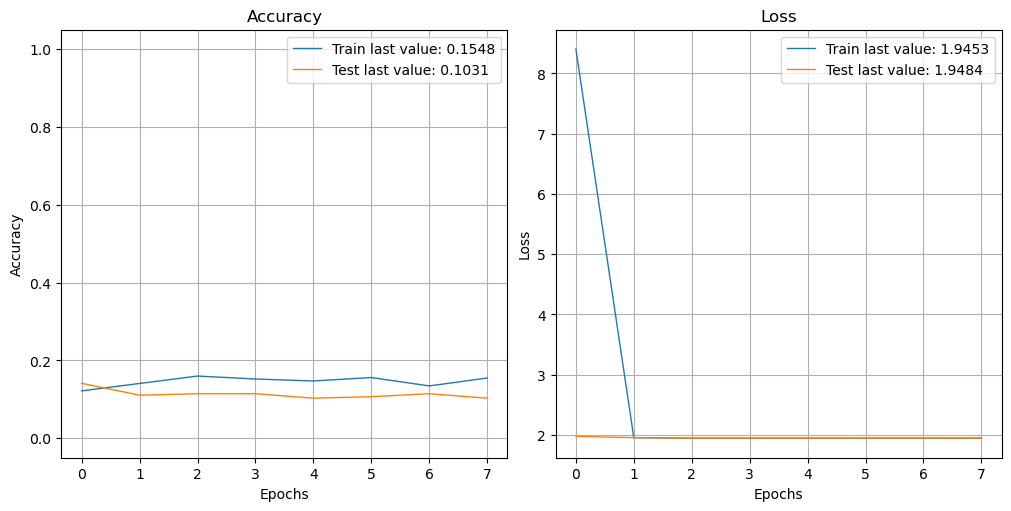

In [60]:
# Visualisation de l'historique de l'entraînement
from plot_keras_history import show_history, plot_history

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

In [158]:
from sklearn.metrics import confusion_matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step
Approche 2 - Avec Data Generator et Data Augmentation
                            precision    recall  f1-score   support

                 Baby Care       0.00      0.00      0.00        38
  Beauty and Personal Care       0.00      0.00      0.00        27
                 Computers       0.00      0.00      0.00        46
Home Decor & Festive Needs       0.00      0.00      0.00        38
           Home Furnishing       0.00      0.00      0.00        45
          Kitchen & Dining       0.12      1.00      0.21        31
                   Watches       0.00      0.00      0.00        37

                  accuracy                           0.12       262
                 macro avg       0.02      0.14      0.03       262
              weighted avg       0.01      0.12      0.03       262



C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


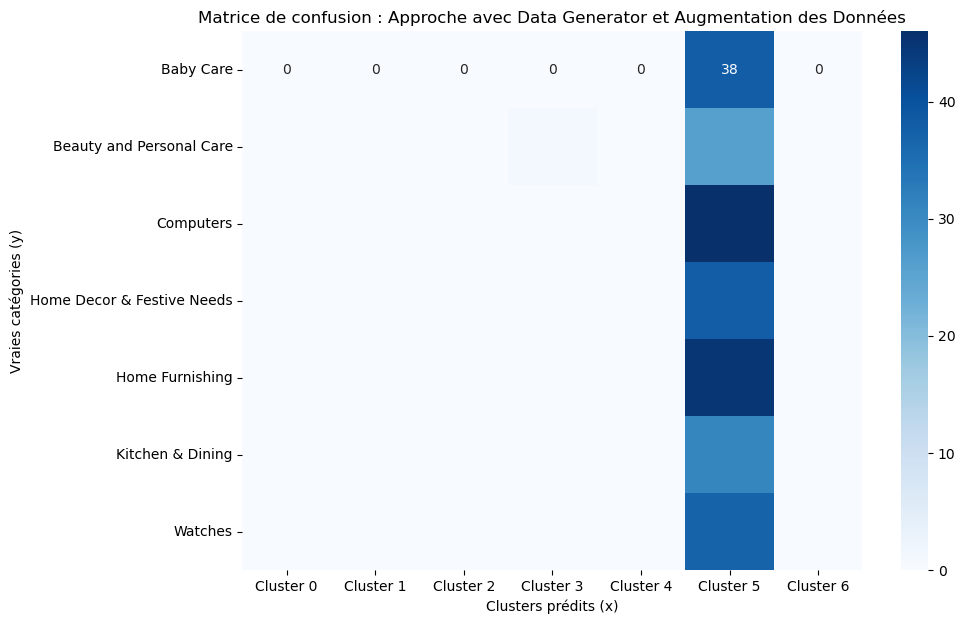

In [66]:
from sklearn.metrics import classification_report, confusion_matrix

# Supposons que vous avez défini `list_labels` comme les catégories réelles
list_labels = list(test_flow.class_indices.keys())  # Liste des catégories réelles du générateur

# Prédictions du modèle sur le jeu de validation
y_val_pred_prob = model2.predict(val_flow, verbose=1)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)  # Convertir les probabilités en classes prédites

# Obtenir les vraies étiquettes du jeu de validation
y_val_true = val_flow.classes  # Indices des vraies catégories

# Calcul du rapport de classification
print("Approche 2 - Avec Data Generator et Data Augmentation")
print(classification_report(y_val_true, y_val_pred, target_names=list_labels))

# Calcul de la matrice de confusion
conf_mat = confusion_matrix(y_val_true, y_val_pred)

# Création du DataFrame pour la heatmap
df_cm = pd.DataFrame(conf_mat, index=list_labels, columns=[f'Cluster {i}' for i in range(len(list_labels))])

# Affichage de la heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Clusters prédits (x)')
plt.ylabel('Vraies catégories (y)')
plt.title('Matrice de confusion : Approche avec Data Generator et Augmentation des Données')
plt.show()

# 3.4. Approche nouvelle par Dataset sans data augmentation
CF https://www.tensorflow.org/tutorials/load_data/images

In [70]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from plot_keras_history import show_history, plot_history
import os

import shutil
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [ ]:
# charger et diviser les images :

In [74]:
# Charger le DataFrame
data = pd.read_csv('data.csv')

# Paramètres
batch_size = 32
image_size = (224, 224)
image_dir = r'C:\Users\SOUKA\Documents\Images'  # Le dossier contenant toutes les images

In [76]:
# Diviser les données en jeux d'entraînement, validation et test
train_df, temp_df = train_test_split(data, test_size=0.40, stratify=data['main_category'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['main_category'], random_state=42)

def create_dataset_from_dataframe(df, image_dir, batch_size=32, image_size=(224, 224)):
    """
    Crée un dataset à partir d'un DataFrame contenant les chemins des images et les catégories.
    """
    def load_image(image_file, label):
        image = tf.io.read_file(image_file)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, image_size)
        return image, label

    image_paths = [os.path.join(image_dir, img) for img in df['image'].values]
    labels = pd.get_dummies(df['main_category']).values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

# Créer les datasets
train_dataset = create_dataset_from_dataframe(train_df, image_dir, batch_size=batch_size, image_size=image_size)
val_dataset = create_dataset_from_dataframe(val_df, image_dir, batch_size=batch_size, image_size=image_size)
test_dataset = create_dataset_from_dataframe(test_df, image_dir, batch_size=batch_size, image_size=image_size)

In [78]:
# Définir la fonction pour créer le modèle
def create_model_fct(input_shape=(224, 224, 3), num_classes=7):
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
3. Création et entraînement du modèle :
Une fois que les datasets sont créés, tu peux passer à la création du modèle et à l'entraînement comme dans ton code initial.

In [80]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création des callbacks
model3_save_path = "./model3_best_weights.keras"  # Changer l'extension en .keras
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Entraînement du modèle
with tf.device('/gpu:0'): 
    history3 = model3.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        callbacks=callbacks_list,
        verbose=1
    )

# Pour charger les poids du modèle sauvegardé
model3.load_weights(model3_save_path)


Epoch 1/10


C:\Users\SOUKA\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.1651 - loss: 205.9531
Epoch 1: val_loss improved from inf to 1.80021, saving model to ./model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 722ms/step - accuracy: 0.1660 - loss: 200.3657 - val_accuracy: 0.2952 - val_loss: 1.8002
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.3574 - loss: 1.6480
Epoch 2: val_loss improved from 1.80021 to 1.73510, saving model to ./model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 722ms/step - accuracy: 0.3559 - loss: 1.6495 - val_accuracy: 0.3667 - val_loss: 1.7351
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.5141 - loss: 1.3246
Epoch 3: val_loss improved from 1.73510 to 1.70666, saving model to ./model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 749ms/step - accuracy: 0.5144 - loss: 1.3251 - val_accuracy: 0.3714 - val_loss: 1.7067
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.6281 - loss: 1.1027
Epoch 4: val_loss did not

In [82]:
# Évaluation du modèle
loss, accuracy = model3.evaluate(train_dataset, verbose=True)
print(f"Training Accuracy   : {accuracy:.4f}")

loss, accuracy = model3.evaluate(val_dataset, verbose=True)
print(f"Validation Accuracy :  {accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.7059 - loss: 0.9105
Training Accuracy   : 0.7286
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.3763 - loss: 1.7090
Validation Accuracy :  0.3714


In [84]:
# Charger les meilleurs poids
model3.load_weights(model3_save_path)

In [86]:
# Évaluer sur le jeu de validation et de test
loss, accuracy = model3.evaluate(val_dataset, verbose=False)
print(f"Validation Accuracy :  {accuracy:.4f}")

loss, accuracy = model3.evaluate(test_dataset, verbose=False)
print(f"Test Accuracy       :  {accuracy:.4f}")

Validation Accuracy :  0.3714
Test Accuracy       :  0.4333


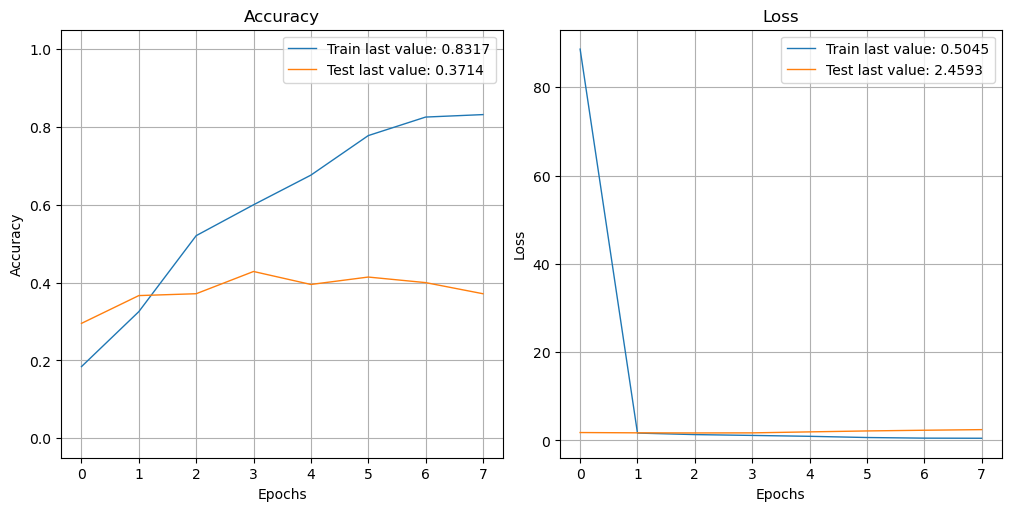

In [88]:
# Visualisation de l'historique d'entraînement
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

In [96]:
# Obtenir les vraies étiquettes du jeu de test
y_test_true = np.concatenate([np.argmax(labels.numpy(), axis=1) for images, labels in test_dataset], axis=0)

# Obtenir les prédictions du modèle
y_test_pred_prob = model3.predict(test_dataset, verbose=1)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


In [98]:
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
conf_mat = confusion_matrix(y_test_true, y_test_pred)

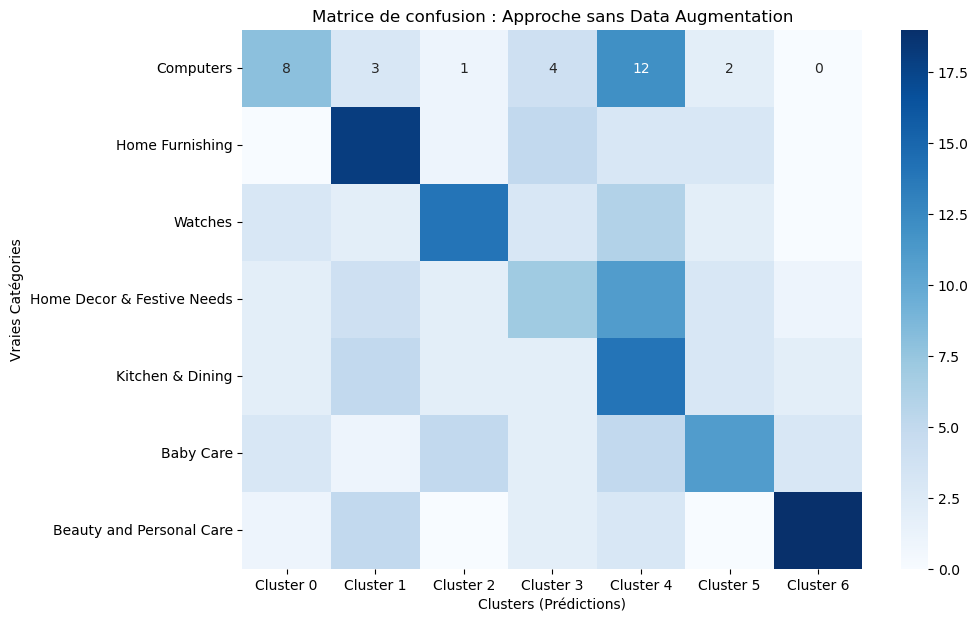

In [100]:
# Liste des catégories réelles
list_labels = test_df['main_category'].unique()

# Créer un DataFrame pour la matrice de confusion
df_cm = pd.DataFrame(conf_mat, index=list_labels, columns=[f'Cluster {i}' for i in range(len(list_labels))])

# Affichage de la heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Clusters (Prédictions)')
plt.ylabel('Vraies Catégories')
plt.title('Matrice de confusion : Approche sans Data Augmentation')
plt.show()

In [92]:
from sklearn.metrics import classification_report

# Calculer le rapport de classification
print("Classification Report - Approach 3")
print(classification_report(y_test_true, y_test_pred, target_names=test_df['main_category'].unique()))

Classification Report - Approach 3
                            precision    recall  f1-score   support

                 Computers       0.42      0.27      0.33        30
           Home Furnishing       0.47      0.60      0.53        30
                   Watches       0.56      0.47      0.51        30
Home Decor & Festive Needs       0.28      0.23      0.25        30
          Kitchen & Dining       0.26      0.47      0.33        30
                 Baby Care       0.46      0.37      0.41        30
  Beauty and Personal Care       0.76      0.63      0.69        30

                  accuracy                           0.43       210
                 macro avg       0.46      0.43      0.44       210
              weighted avg       0.46      0.43      0.44       210



# 3.5. Approche nouvelle par Dataset avec data augmentation intégrée au modèle
CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [125]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [127]:
# Chemin des images
image_dir = r'C:\Users\SOUKA\Documents\Images'


In [129]:
# Charger le DataFrame
data = pd.read_csv('data.csv')


In [131]:
# Obtenir les chemins complets des images et leurs labels
data['image_path'] = data['image'].apply(lambda img: os.path.join(image_dir, img))
image_paths = data['image_path'].values
labels = pd.get_dummies(data['main_category']).values  # Encodage One-hot des catégories

In [133]:
# Division Entraînement/Test (80% pour Entraînement/Validation, 20% pour Test)
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.20, random_state=42)

# Division Entraînement/Validation (75% de l'ensemble Entraînement/Validation pour Entraînement, 25% pour Validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=42)

In [135]:
# Générateur personnalisé pour le test
def image_data_generator(image_paths, labels, batch_size, image_size):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            
            images = [img_to_array(load_img(img_path, target_size=image_size)) / 255.0 for img_path in batch_paths]
            yield np.array(images), np.array(batch_labels)

# Créez le générateur de test
test_dataset = image_data_generator(test_paths, test_labels, batch_size, (224, 224))

# Vérifiez le générateur de test
for images, labels in test_dataset:
    print(images.shape, labels.shape)  # Vérifiez les dimensions
    break  # Juste pour tester une itération

(32, 224, 224, 3) (32, 7)


In [37]:
# Générateur personnalisé  (à supprimer si le précédent marche)
def image_data_generator(image_paths, labels, batch_size, image_size):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            
            images = [img_to_array(load_img(img_path, target_size=image_size)) / 255.0 for img_path in batch_paths]
            yield tf.convert_to_tensor(images), tf.convert_to_tensor(batch_labels)



In [137]:
# Paramètres
batch_size = 32
image_size = (224, 224)

In [139]:
# Générateurs de données 
train_dataset = image_data_generator(train_paths, train_labels, batch_size, image_size)
val_dataset = image_data_generator(val_paths, val_labels, batch_size, image_size)
test_dataset = image_data_generator(test_paths, test_labels, batch_size, image_size)


In [141]:
# Modèle avec data augmentation 
def create_model_fct2():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])
    
    # Modèle pré-entraîné VGG16
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du modèle complet
    model = Sequential([
        data_augmentation,
        Rescaling(1./127.5, offset=-1),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(labels[0]), activation='softmax')  # Nombre de catégories
    ])
    
    # Compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model



In [143]:
# Création du modèle
with tf.device('/gpu:0'):
    model4 = create_model_fct2()

C:\Users\SOUKA\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [145]:
# Callbacks
model4_save_path = "./model4_best_weights.keras"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [147]:
# Entraînement du modèle 
with tf.device('/gpu:0'):
    history4 = model4.fit(
        train_dataset,
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=val_dataset,
        validation_steps=len(val_paths) // batch_size,
        epochs=10,
        callbacks=callbacks_list,
        verbose=1
    )

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1181 - loss: 2.1729
Epoch 1: val_loss improved from inf to 1.95468, saving model to ./model4_best_weights.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.1186 - loss: 2.1705 - val_accuracy: 0.1354 - val_loss: 1.9547
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1478 - loss: 2.0576
Epoch 2: val_loss improved from 1.95468 to 1.94910, saving model to ./model4_best_weights.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.1469 - loss: 2.0573 - val_accuracy: 0.1011 - val_loss: 1.9491
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1440 - loss: 1.9933
Epoch 3: val_loss did not improve from 1.94910
19/19 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.1434 - loss: 1.9929 - val_accuracy: 0.1461 - val_loss: 1.9497
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1549 - loss: 1.9611
Epoch 4: val_loss improved from 1.94910 to 1.94824, saving model to ./model4_best_wei

In [149]:
# Évaluation
loss, accuracy = model4.evaluate(test_dataset, steps=len(test_paths) // batch_size)
print(f"Test Accuracy : {accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.1152 - loss: 1.9542
Test Accuracy : 0.1250


19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.1335 - loss: 1.9441
Training Accuracy   : 0.1472
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.1194 - loss: 1.9529
Validation Accuracy : 0.1404
Test Accuracy       : 0.1250


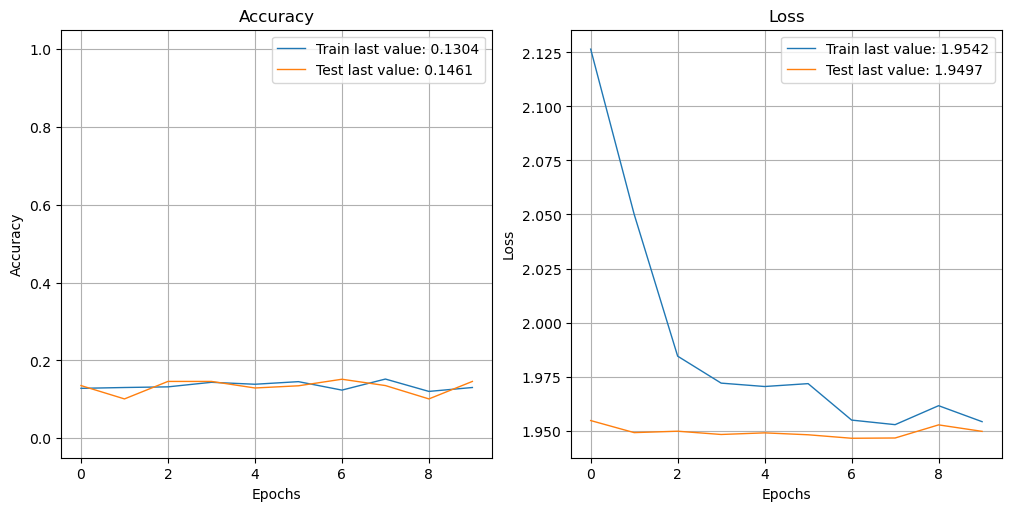

In [151]:
# Évaluation du modèle sur le jeu d'entraînement
loss, accuracy = model4.evaluate(train_dataset, steps=len(train_paths) // batch_size, verbose=True)
print(f"Training Accuracy   : {accuracy:.4f}")

# Évaluation du modèle sur le jeu de validation
loss, accuracy = model4.evaluate(val_dataset, steps=len(val_paths) // batch_size, verbose=True)
print(f"Validation Accuracy : {accuracy:.4f}")

# Charger les meilleurs poids enregistrés
model4.load_weights(model4_save_path)

# Évaluation du modèle sur le jeu de test
loss, accuracy = model4.evaluate(test_dataset, steps=len(test_paths) // batch_size, verbose=False)
print(f"Test Accuracy       : {accuracy:.4f}")

# Afficher les courbes d'apprentissage
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

** Interprétation et comparaison des résultats des 4 approches **
**********

voici une interprétation des résultats de vos 4 approches en fonction de trois critères : test accuracy, test loss, et temps d'entraînement. Commençons par analyser chaque approche individuellement avant de faire des comparaisons globales.

Interprétation individuelle des résultats

Approche            	Test Accuracy	Test Loss	Temps (s)

Simple (préparation initiale)	0.2952	3.1414	4

Data Generator avec data augmentation	0.1429	1.9484	141

DataSet, sans data augmentation	0.4305	1.7090	5

DataSet, avec data augmentation	0.1198	1.9579	139



Simple (préparation initiale) :

- Test accuracy de 0.2952 : Cela signifie que le modèle a réussi à prédire correctement environ 29,52 % des exemples sur l'ensemble de test, ce qui est relativement faible.
- Test loss de 3.1414 : Un test loss élevé indique que le modèle a rencontré beaucoup de difficultés à prédire correctement les classes.
- Temps d'entraînement de 4 secondes : Le modèle est très rapide à entraîner, mais cela semble venir au prix de performances très médiocres.
  
Data Generator avec data augmentation :

- Test accuracy de 0.1429 : Le modèle n'a réussi qu'à prédire correctement environ 14,29 % des exemples, ce qui est très faible.
- Test loss de 1.9484 : Bien que la test accuracy soit basse, la perte est plus faible que dans l'approche précédente, ce qui pourrait indiquer que le modèle fait des prédictions moins éloignées des valeurs réelles, mais manque de généralisation.
- Temps d'entraînement de 141 secondes : Cette approche prend significativement plus de temps à entraîner à cause des opérations supplémentaires introduites par la data augmentation.
  
DataSet, sans data augmentation :

- Test accuracy de 0.4305 : C'est l'approche qui donne la meilleure précision de test, avec 43,05 % de bonnes prédictions.
- Test loss de 1.7090 : Cette approche présente également la plus faible perte de test, ce qui indique que le modèle apprend mieux à prédire les classes que dans les autres approches.
- Temps d'entraînement de 5 secondes : C'est un modèle rapide à entraîner, et il donne de loin les meilleurs résultats en termes de test accuracy et test loss.
  
DataSet, avec data augmentation :

- Test accuracy de 0.1198 : Cette approche donne les pires résultats en termes de précision de test (11,98 %).
- Test loss de 1.9579 : La perte est similaire à celle de l'approche utilisant la data augmentation avec le data generator, ce qui montre que l'augmentation des données semble ne pas aider à améliorer les performances du modèle.
- Temps d'entraînement de 139 secondes : Tout comme l'approche avec le data generator, l'ajout de data augmentation augmente considérablement le temps d'entraînement.

  Comparaison des approches
  
Test accuracy :

L'approche DataSet sans data augmentation a la meilleure précision (0.4305), ce qui signifie que, sans augmentation des données, le modèle est capable de mieux généraliser sur les nouvelles données.

L'approche Simple arrive en deuxième position avec une test accuracy de 0.2952.

Les approches avec data augmentation donnent de très faibles précisions, ce qui pourrait indiquer que le modèle n'est pas encore bien adapté pour apprendre à partir de données modifiées artificiellement.

Test loss :

L'approche DataSet sans data augmentation a également la plus faible perte (1.7090), ce qui est cohérent avec sa meilleure précision. Cela montre que ce modèle fait des erreurs moins graves par rapport aux autres modèles.

Les pertes des modèles avec data augmentation sont similaires, mais les précisions sont très basses, ce qui pourrait indiquer que les augmentations de données sont mal configurées ou ne sont pas adaptées à ce problème particulier.

Temps d'entraînement :

Les approches utilisant la data augmentation sont significativement plus lentes à entraîner (environ 140 secondes contre 4 à 5 secondes pour les autres). Cela est dû aux opérations supplémentaires (flips, rotations, zooms, etc.) appliquées aux images avant de les alimenter au réseau.

L'approche Simple est la plus rapide, mais cela se fait au détriment de la performance, avec une précision relativement faible.


Interprétation globale

L'approche la plus performante en termes de test accuracy et de test loss est l'approche DataSet sans data augmentation. Elle est rapide à entraîner et offre les meilleurs résultats.

Les approches avec data augmentation n'ont pas donné de bons résultats, malgré un entraînement plus long. Cela peut indiquer que la data augmentation utilisée n'est pas bénéfique dans ce cas précis, probablement parce que les transformations appliquées perturbent le modèle plus qu'elles ne l'aident à mieux généraliser.

L'approche Simple a des résultats acceptables pour le temps d'entraînement extrêmement rapide, mais elle est surpassée par l'approche sans augmentation.